In [7]:
import pandas as pd
parquet_path = "C:/Users/Leon/Documents/Github/CPE025A/df_parquet.parquet"
df_parquet = pd.read_parquet(parquet_path)
df_parquet.head()

,Ammonia (mg/l),pH (ph units),Nitrate (mg/l),CCME_Values,cluster,class_label
0,0.05152,8.3700,9.73940,100.0,5,B2
1,0.07728,8.0167,8.72119,100.0,5,B2
2,0.09016,7.7900,9.51805,100.0,1,A2
3,0.10304,8.1583,8.63265,100.0,5,B2
4,0.10304,7.7900,8.76546,100.0,1,A2


In [8]:
print("Number of datapoints (rows):", df_parquet.shape[0])

Number of datapoints (rows): 1674462


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = df_parquet.drop(columns=['cluster','class_label'], axis=1)
y = df_parquet['cluster']

# Split sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Training on 100 samples

--- RandomForest ---
Training time: 0.4290s | Prediction time: 5.3497s
Accuracy: 0.7915 | Misclassification Rate: 0.2085

--- XGBoost ---
Training time: 0.5981s | Prediction time: 1.9674s
Accuracy: 0.6993 | Misclassification Rate: 0.3007

--- CatBoost ---
Training time: 1.1389s | Prediction time: 0.2705s
Accuracy: 0.8135 | Misclassification Rate: 0.1865

Training on 1000 samples

--- RandomForest ---
Training time: 0.5471s | Prediction time: 5.0496s
Accuracy: 0.9266 | Misclassification Rate: 0.0734

--- XGBoost ---
Training time: 1.1761s | Prediction time: 2.7152s
Accuracy: 0.9420 | Misclassification Rate: 0.0580

--- CatBoost ---
Training time: 5.1439s | Prediction time: 0.2945s
Accuracy: 0.9467 | Misclassification Rate: 0.0533

Training on 10000 samples

--- RandomForest ---
Training time: 0.7451s | Prediction time: 5.0449s
Accuracy: 0.9513 | Misclassification Rate: 0.0487

--- XGBoost ---
Training time: 2.5028s | Prediction time: 4.3737s
Accuracy: 0.9737 | 

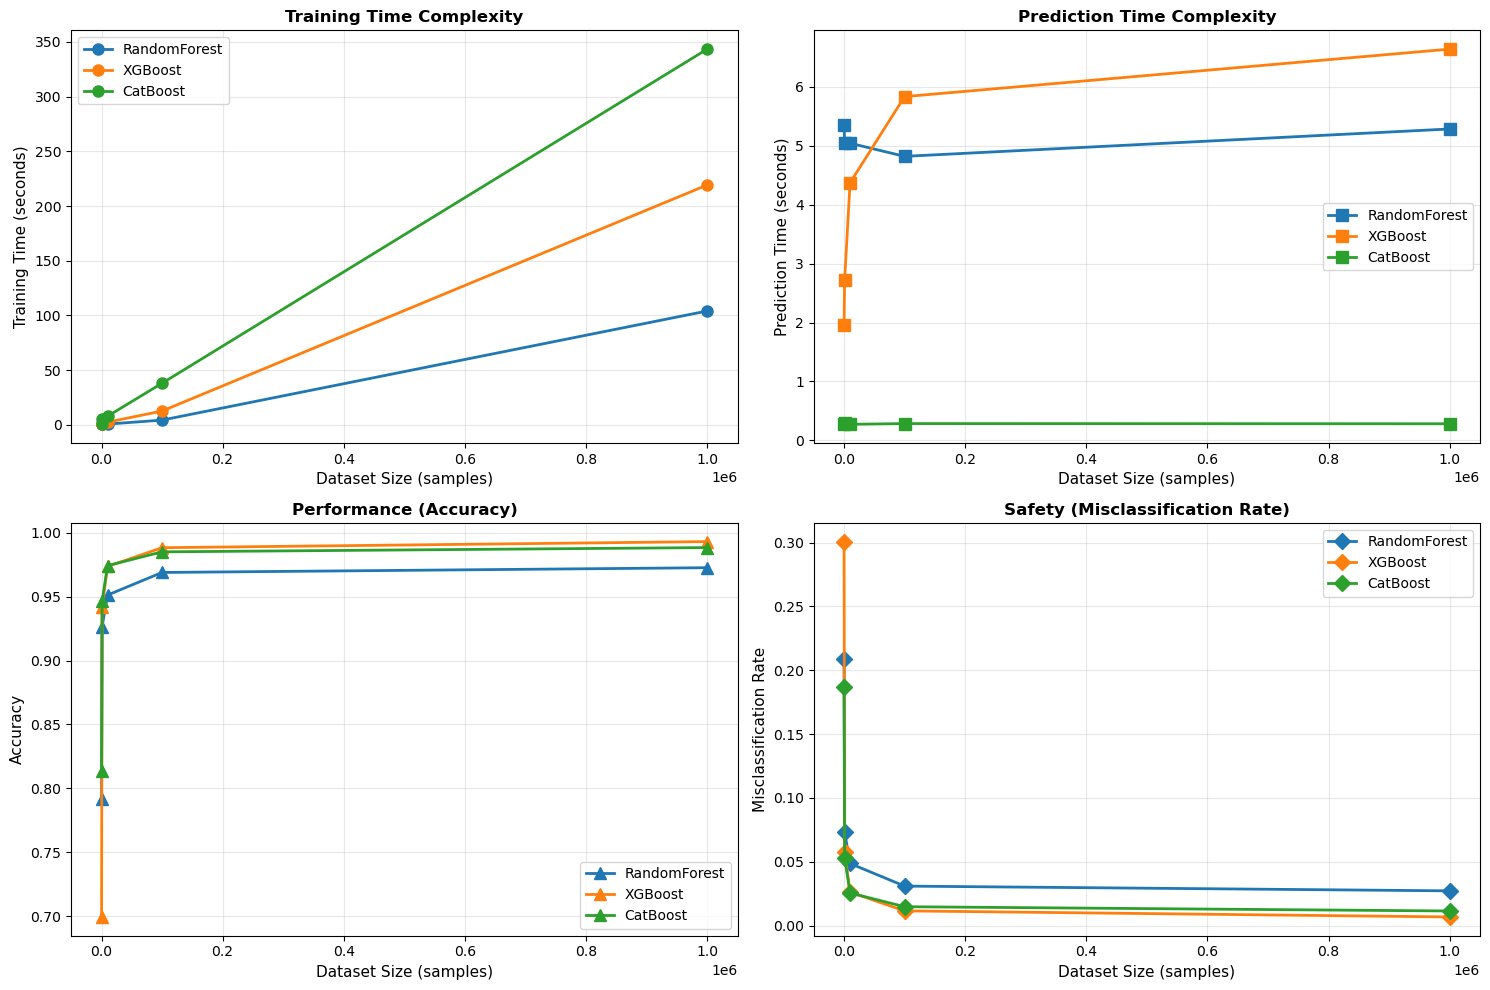



RUNTIME COMPLEXITY & PERFORMANCE SUMMARY

RANDOMFOREST
----------------------------------------------------------------------------------------------------
Size       Train Time (s)     Pred Time (s)      Accuracy        Misclass Rate  
----------------------------------------------------------------------------------------------------
100        0.4290             5.3497             0.7915          0.2085         
1000       0.5471             5.0496             0.9266          0.0734         
10000      0.7451             5.0449             0.9513          0.0487         
100000     4.4175             4.8221             0.9690          0.0310         
1000000    104.1105           5.2870             0.9727          0.0273         

XGBOOST
----------------------------------------------------------------------------------------------------
Size       Train Time (s)     Pred Time (s)      Accuracy        Misclass Rate  
----------------------------------------------------------------

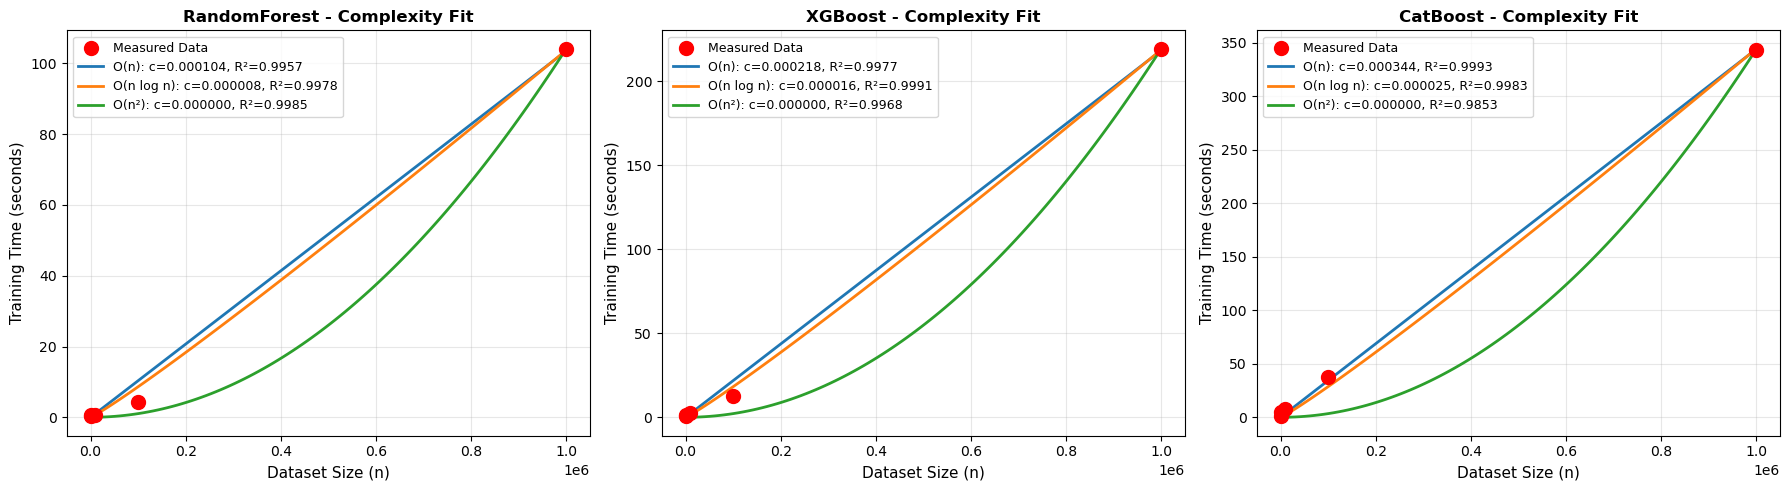



STORAGE CONSUMPTION
RandomForest: 114.4513 MB
XGBoost: 24.6854 MB
CatBoost: 4.2130 MB

ANALYSIS COMPLETE


In [10]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import os

# Define dataset sizes to test
dataset_sizes = [100, 1000, 10000, 100000, 1000000]

# Store results for all three models
results = {
    'RandomForest': {'sizes': [], 'training_times': [], 'prediction_times': [], 'accuracies': [], 'misclassification_rates': []},
    'XGBoost': {'sizes': [], 'training_times': [], 'prediction_times': [], 'accuracies': [], 'misclassification_rates': []},
    'CatBoost': {'sizes': [], 'training_times': [], 'prediction_times': [], 'accuracies': [], 'misclassification_rates': []}
}

# Train each model on different dataset sizes
for size in dataset_sizes:
    if size > len(X_train_scaled):
        print(f"Skipping size {size} - exceeds available data")
        continue
    
    print(f"\n{'='*60}")
    print(f"Training on {size} samples")
    print(f"{'='*60}")
    
    # Subset the data
    X_train_subset = X_train_scaled[:size]
    y_train_subset = y_train.iloc[:size]
    
    # ========== RANDOM FOREST ==========
    print("\n--- RandomForest ---")
    rf = RandomForestClassifier(n_estimators=400, 
                                random_state=42, 
                                n_jobs=-1,
                                class_weight='balanced',
                                min_samples_split=5, 
                                min_samples_leaf=10, 
                                max_depth=10)
    
    start_train = time.time()
    rf.fit(X_train_subset, y_train_subset)
    train_time_rf = time.time() - start_train
    
    start_pred = time.time()
    rf_predictions = rf.predict(X_test_scaled)
    pred_time_rf = time.time() - start_pred
    
    rf_accuracy = accuracy_score(y_test, rf_predictions)
    rf_misclass_rate = 1 - rf_accuracy
    
    results['RandomForest']['sizes'].append(size)
    results['RandomForest']['training_times'].append(train_time_rf)
    results['RandomForest']['prediction_times'].append(pred_time_rf)
    results['RandomForest']['accuracies'].append(rf_accuracy)
    results['RandomForest']['misclassification_rates'].append(rf_misclass_rate)
    
    print(f"Training time: {train_time_rf:.4f}s | Prediction time: {pred_time_rf:.4f}s")
    print(f"Accuracy: {rf_accuracy:.4f} | Misclassification Rate: {rf_misclass_rate:.4f}")
    
    # ========== XGBOOST ==========
    print("\n--- XGBoost ---")
    xgb = XGBClassifier(n_estimators=500,
                        learning_rate=0.05,
                        max_depth=6,
                        objective='multi:softprob',
                        eval_metric='logloss', 
                        random_state=42, 
                        n_jobs=-1,
                        verbosity=0)
    
    start_train = time.time()
    xgb.fit(X_train_subset, y_train_subset)
    train_time_xgb = time.time() - start_train
    
    start_pred = time.time()
    xgb_predictions = xgb.predict(X_test_scaled)
    pred_time_xgb = time.time() - start_pred
    
    xgb_accuracy = accuracy_score(y_test, xgb_predictions)
    xgb_misclass_rate = 1 - xgb_accuracy
    
    results['XGBoost']['sizes'].append(size)
    results['XGBoost']['training_times'].append(train_time_xgb)
    results['XGBoost']['prediction_times'].append(pred_time_xgb)
    results['XGBoost']['accuracies'].append(xgb_accuracy)
    results['XGBoost']['misclassification_rates'].append(xgb_misclass_rate)
    
    print(f"Training time: {train_time_xgb:.4f}s | Prediction time: {pred_time_xgb:.4f}s")
    print(f"Accuracy: {xgb_accuracy:.4f} | Misclassification Rate: {xgb_misclass_rate:.4f}")
    
    # ========== CATBOOST ==========
    print("\n--- CatBoost ---")
    cb = CatBoostClassifier(iterations=500,
                            learning_rate=0.05,
                            depth=6,
                            eval_metric='Accuracy', 
                            random_state=42,
                            verbose=0)
    
    start_train = time.time()
    cb.fit(X_train_subset, y_train_subset)
    train_time_cb = time.time() - start_train
    
    start_pred = time.time()
    cb_predictions = cb.predict(X_test_scaled)
    pred_time_cb = time.time() - start_pred
    
    cb_accuracy = accuracy_score(y_test, cb_predictions)
    cb_misclass_rate = 1 - cb_accuracy
    
    results['CatBoost']['sizes'].append(size)
    results['CatBoost']['training_times'].append(train_time_cb)
    results['CatBoost']['prediction_times'].append(pred_time_cb)
    results['CatBoost']['accuracies'].append(cb_accuracy)
    results['CatBoost']['misclassification_rates'].append(cb_misclass_rate)
    
    print(f"Training time: {train_time_cb:.4f}s | Prediction time: {pred_time_cb:.4f}s")
    print(f"Accuracy: {cb_accuracy:.4f} | Misclassification Rate: {cb_misclass_rate:.4f}")

# ========== VISUALIZE RESULTS ==========
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Time Complexity
ax = axes[0, 0]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['training_times'], 
            marker='o', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Training Time (seconds)', fontsize=11)
ax.set_title('Training Time Complexity', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Prediction Time Complexity
ax = axes[0, 1]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['prediction_times'], 
            marker='s', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Prediction Time (seconds)', fontsize=11)
ax.set_title('Prediction Time Complexity', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Accuracy vs Dataset Size
ax = axes[1, 0]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['accuracies'], 
            marker='^', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Performance (Accuracy)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Misclassification Rate
ax = axes[1, 1]
for model_name in results.keys():
    ax.plot(results[model_name]['sizes'], results[model_name]['misclassification_rates'], 
            marker='D', label=model_name, linewidth=2, markersize=8)
ax.set_xlabel('Dataset Size (samples)', fontsize=11)
ax.set_ylabel('Misclassification Rate', fontsize=11)
ax.set_title('Safety (Misclassification Rate)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== PRINT SUMMARY TABLE ==========
print("\n\n" + "="*100)
print("RUNTIME COMPLEXITY & PERFORMANCE SUMMARY")
print("="*100)

for model_name in results.keys():
    print(f"\n{model_name.upper()}")
    print("-" * 100)
    print(f"{'Size':<10} {'Train Time (s)':<18} {'Pred Time (s)':<18} {'Accuracy':<15} {'Misclass Rate':<15}")
    print("-" * 100)
    
    for i, size in enumerate(results[model_name]['sizes']):
        print(f"{size:<10} {results[model_name]['training_times'][i]:<18.4f} "
              f"{results[model_name]['prediction_times'][i]:<18.4f} "
              f"{results[model_name]['accuracies'][i]:<15.4f} "
              f"{results[model_name]['misclassification_rates'][i]:<15.4f}")

# ========== RUNTIME COMPLEXITY FORMULAS ==========
print("\n\n" + "="*100)
print("RUNTIME COMPLEXITY ANALYSIS - FORMULA FITTING")
print("="*100)

# Define complexity functions
def linear(n, c):
    return c * n

def linearithmic(n, c):
    return c * n * np.log(n)

def quadratic(n, c):
    return c * n**2

# Fit complexity formulas for each model
complexity_results = {}

for model_name in results.keys():
    print(f"\n{model_name.upper()}")
    print("-" * 100)
    
    sizes = np.array(results[model_name]['sizes'], dtype=float)
    times = np.array(results[model_name]['training_times'], dtype=float)
    
    # Avoid log(0) errors
    if np.any(sizes <= 0):
        print("Skipping - invalid size data")
        continue
    
    complexity_results[model_name] = {}
    
    # Fit Linear O(n)
    try:
        popt_linear, _ = curve_fit(linear, sizes, times, maxfev=5000)
        residuals = times - linear(sizes, *popt_linear)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((times - np.mean(times))**2)
        r2_linear = 1 - (ss_res / ss_tot)
        
        complexity_results[model_name]['linear'] = {'c': popt_linear[0], 'r2': r2_linear}
        print(f"O(n):        T(n) = {popt_linear[0]:.8f} * n          | R² = {r2_linear:.6f}")
    except Exception as e:
        print(f"O(n):        Failed to fit - {str(e)}")
    
    # Fit Linearithmic O(n log n)
    try:
        popt_linlog, _ = curve_fit(linearithmic, sizes, times, maxfev=5000)
        residuals = times - linearithmic(sizes, *popt_linlog)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((times - np.mean(times))**2)
        r2_linlog = 1 - (ss_res / ss_tot)
        
        complexity_results[model_name]['linearithmic'] = {'c': popt_linlog[0], 'r2': r2_linlog}
        print(f"O(n log n):  T(n) = {popt_linlog[0]:.8f} * n*log(n)  | R² = {r2_linlog:.6f}")
    except Exception as e:
        print(f"O(n log n):  Failed to fit - {str(e)}")
    
    # Fit Quadratic O(n²)
    try:
        popt_quad, _ = curve_fit(quadratic, sizes, times, maxfev=5000)
        residuals = times - quadratic(sizes, *popt_quad)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((times - np.mean(times))**2)
        r2_quad = 1 - (ss_res / ss_tot)
        
        complexity_results[model_name]['quadratic'] = {'c': popt_quad[0], 'r2': r2_quad}
        print(f"O(n²):       T(n) = {popt_quad[0]:.8f} * n²        | R² = {r2_quad:.6f}")
    except Exception as e:
        print(f"O(n²):       Failed to fit - {str(e)}")
    
    # Determine best fit
    best_fit = max([(k, v['r2']) for k, v in complexity_results[model_name].items()], key=lambda x: x[1])
    print(f"\n✓ BEST FIT: O({best_fit[0]}) with R² = {best_fit[1]:.6f}")

# ========== VISUALIZE COMPLEXITY FITS ==========
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_names = list(results.keys())
for idx, model_name in enumerate(model_names):
    ax = axes[idx]
    
    sizes = np.array(results[model_name]['sizes'], dtype=float)
    times = np.array(results[model_name]['training_times'], dtype=float)
    
    # Plot actual data
    ax.scatter(sizes, times, s=100, color='red', label='Measured Data', zorder=3)
    
    # Plot fitted curves
    sizes_smooth = np.linspace(sizes.min(), sizes.max(), 100)
    
    if 'linear' in complexity_results.get(model_name, {}):
        c = complexity_results[model_name]['linear']['c']
        r2 = complexity_results[model_name]['linear']['r2']
        ax.plot(sizes_smooth, linear(sizes_smooth, c), 
                label=f"O(n): c={c:.6f}, R²={r2:.4f}", linewidth=2)
    
    if 'linearithmic' in complexity_results.get(model_name, {}):
        c = complexity_results[model_name]['linearithmic']['c']
        r2 = complexity_results[model_name]['linearithmic']['r2']
        ax.plot(sizes_smooth, linearithmic(sizes_smooth, c), 
                label=f"O(n log n): c={c:.6f}, R²={r2:.4f}", linewidth=2)
    
    if 'quadratic' in complexity_results.get(model_name, {}):
        c = complexity_results[model_name]['quadratic']['c']
        r2 = complexity_results[model_name]['quadratic']['r2']
        ax.plot(sizes_smooth, quadratic(sizes_smooth, c), 
                label=f"O(n²): c={c:.6f}, R²={r2:.4f}", linewidth=2)
    
    ax.set_xlabel('Dataset Size (n)', fontsize=11)
    ax.set_ylabel('Training Time (seconds)', fontsize=11)
    ax.set_title(f'{model_name} - Complexity Fit', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== MEASURE STORAGE CONSUMPTION ==========
print("\n\n" + "="*100)
print("STORAGE CONSUMPTION")
print("="*100)

import joblib

for model_name, model_obj in [('RandomForest', rf), ('XGBoost', xgb), ('CatBoost', cb)]:
    filename = f"{model_name}_model.pkl"
    joblib.dump(model_obj, filename)
    file_size_mb = os.path.getsize(filename) / (1024 * 1024)
    print(f"{model_name}: {file_size_mb:.4f} MB")
    os.remove(filename)  # Clean up

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)


In [11]:
from scipy.optimize import curve_fit
import numpy as np

# Measured training times
sizes = np.array([100, 1000, 10000, 100000, 1000000])
times = np.array([1.14, 5.14, 7.98, 38.10, 343.37])  # CatBoost

def linear(n, c):
    return c * n

# Fit the linear formula to get optimal c
c_opt, _ = curve_fit(linear, sizes, times)
predicted = linear(sizes, c_opt[0])

# How well does the predicted time match actual time? (measured by R²)
ss_res = np.sum((times - predicted)**2)
ss_tot = np.sum((times - np.mean(times))**2)
r2 = 1 - ss_res / ss_tot
